In [2]:
library(tidyverse); library(lubridate); library(readxl); library(data.table)
library(fixest)
library(rdrobust); library(broom)
library(modelsummary)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'readxl' was built under R version 4.3.3"
Warning message:
"package 'data.table' was built under R version 4.3.3"

Attaching package: 'data.table'


The following objects

ERROR: Error in library(modelsummary): there is no package called 'modelsummary'


In [24]:
usdc_raw <- read_csv("C:/Users/chris/OneDrive/桌面/毕业论文/usdc.csv")
usdt_raw <- read_csv("C:/Users/chris/OneDrive/桌面/毕业论文/usdt.csv")
mps_raw  <- read_excel("C:/Users/chris/OneDrive/桌面/毕业论文/monetary-policy-surprises-data.xlsx") 


Rows: 2606 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): snapped_at
dbl (3): price, market_cap, total_volume

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3901 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): snapped_at
dbl (3): price, market_cap, total_volume

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [45]:
mps <- mps_raw %>%
  select(Date = 1, MPS = 16) %>%   
  mutate(Date = as_date(Date)) %>%        
  filter(Date >= as_date("2018-10-05")) %>%
  drop_na(Date, MPS)
head(mps)

Date,MPS
<date>,<dbl>
2018-11-08,0.01681114
2018-12-19,0.02965432
2019-01-30,-0.01963239
2019-03-20,-0.02703320
2019-05-01,-0.03738036
2019-06-19,-0.07928805


In [32]:
usdt <- usdt_raw %>%
  select(snapped_at, total_volume) %>%
  mutate(
    date = as_date(ymd_hms(snapped_at))
  )%>%
  filter(date >= as_date("2018-10-05") & date <= as_date("2023-12-31")) %>%   
  arrange(date) %>%
  select(date, total_volume)

In [33]:
usdc <- usdc_raw %>%
  select(snapped_at, total_volume) %>%
  mutate(
    date = as_date(ymd_hms(snapped_at))
  )%>%
  filter(date >= as_date("2018-10-05") & date <= as_date("2023-12-31")) %>%   
  arrange(date) %>%
  select(date, total_volume)

In [36]:
daily_vol <- usdc %>%
  group_by(date) %>%
  summarise(volume_usdc = sum(total_volume, na.rm=TRUE)) %>%
  full_join(usdt %>% group_by(date) %>% summarise(volume_usdt = sum(total_volume, na.rm=TRUE)),
            by="date") %>%
  arrange(date)
head(daily_vol)

date,volume_usdc,volume_usdt
<date>,<dbl>,<dbl>
2018-10-05,31264.42,109163119
2018-10-06,20254.71,82904991
2018-10-07,49324.69,84072638
2018-10-08,47076.73,65173095
2018-10-09,55542.22,70625466
2018-10-10,41812.50,64067243


In [50]:
fomc <- mps %>% 
    mutate(fomc_id = row_number())
head(fomc)

Date,MPS,fomc_id
<date>,<dbl>,<int>
2018-11-08,0.01681114,1
2018-12-19,0.02965432,2
2019-01-30,-0.01963239,3
2019-03-20,-0.02703320,4
2019-05-01,-0.03738036,5
2019-06-19,-0.07928805,6


In [59]:
window_days <- 3
library(purrr)
ann_windows <- ann %>%
  mutate(dates = map(Date, ~ seq(.x - days(window_days), .x + days(window_days), by="day"))) %>%
  unnest(dates) %>%
  rename(date = dates) %>%
  left_join(daily_vol, by="date") %>%
  mutate(Z = as.numeric(date - Date),      # running variable in days
         D = if_else(Z >= 0, 1, 0),
         log_vol_usdc = log(volume_usdc + 1),
         log_vol_usdt = log(volume_usdt + 1)) %>%
  rename(coin_date = date) %>%
  rename(fomc_date = Date) 

In [60]:
head(ann_windows)

fomc_date,MPS,ann_id,coin_date,volume_usdc,volume_usdt,Z,D,log_vol_usdc,log_vol_usdt
<date>,<dbl>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-11-08,0.01681114,1,2018-11-05,580733.6,66787759,-3,0,13.27205,18.01703
2018-11-08,0.01681114,1,2018-11-06,648445.2,48925898,-2,0,13.38233,17.70582
2018-11-08,0.01681114,1,2018-11-07,662717.4,61192288,-1,0,13.40411,17.92953
2018-11-08,0.01681114,1,2018-11-08,1008705.8,71896266,0,1,13.82418,18.09073
2018-11-08,0.01681114,1,2018-11-09,585822.1,59362584,1,1,13.28077,17.89917
2018-11-08,0.01681114,1,2018-11-10,670938.9,56743017,2,1,13.41643,17.85404


In [74]:
library(estimatr)

# Linear RD with ±3 days window
rd_df <- ann_windows %>% filter(Z >= -3 & Z <= 3)

creg1 <- lm_robust(log_vol_usdc ~ D + Z + D:Z, data = rd_df)
summary(creg1)

treg1 <- lm_robust(log_vol_usdt ~ D + Z + D:Z, data = rd_df)
summary(treg1)


Call:
lm_robust(formula = log_vol_usdc ~ D + Z + D:Z, data = rd_df)

Standard error type:  HC2 

Coefficients:
            Estimate Std. Error t value   Pr(>|t|) CI Lower CI Upper  DF
(Intercept) 21.02544     0.3769 55.7893 1.024e-170  20.2841  21.7668 332
D           -0.08413     0.4247 -0.1981  8.431e-01  -0.9197   0.7514 332
Z            0.08284     0.1714  0.4834  6.291e-01  -0.2542   0.4199 332
D:Z         -0.10429     0.2008 -0.5194  6.038e-01  -0.4993   0.2907 332

Multiple R-squared:  0.001082 ,	Adjusted R-squared:  -0.007945 
F-statistic: 0.1216 on 3 and 332 DF,  p-value: 0.9473


Call:
lm_robust(formula = log_vol_usdt ~ D + Z + D:Z, data = rd_df)

Standard error type:  HC2 

Coefficients:
             Estimate Std. Error   t value   Pr(>|t|) CI Lower CI Upper  DF
(Intercept) 24.203546     0.3382 71.569204 7.359e-204  23.5383  24.8688 332
D           -0.002368     0.3781 -0.006263  9.950e-01  -0.7461   0.7414 332
Z            0.111058     0.1580  0.702710  4.827e-01  -0.1998   0.4219 332
D:Z         -0.128870     0.1826 -0.705707  4.809e-01  -0.4881   0.2304 332

Multiple R-squared:  0.006013 ,	Adjusted R-squared:  -0.002969 
F-statistic: 0.6274 on 3 and 332 DF,  p-value: 0.5978

In [78]:
creg2 <- feols(log_vol_usdc ~ D * Z * I(Z^2) * I(Z^3), data = rd_df, cluster = ~ann_id)
summary(creg2)

treg2 <- feols(log_vol_usdt ~ D * Z * I(Z^2) * I(Z^3), data = rd_df, cluster = ~ann_id)
summary(treg2)

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'Z:I(I(Z^3))',
'I(I(Z^2)):I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))' and 3 others have been
removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 336
Standard-errors: Clustered (ann_id) 
             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 21.889118   0.484917 45.13997 < 2.2e-16 ***
D           -1.027991   0.380403 -2.70238 0.0095487 ** 
Z            1.405217   0.529146  2.65563 0.0107744 *  
I(I(Z^2))    0.575171   0.269698  2.13265 0.0382071 *  
I(I(Z^3))    0.075254   0.043933  1.71293 0.0933160 .  
D:Z         -0.900149   0.315042 -2.85724 0.0063475 ** 
D:I(I(Z^2)) -0.971425   0.483433 -2.00943 0.0502532 .  
... 9 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 7 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.63115   Adj. R2: -0.015301

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'Z:I(I(Z^3))',
'I(I(Z^2)):I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))' and 3 others have been
removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 336
Standard-errors: Clustered (ann_id) 
             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 24.508524   0.315220 77.750556 < 2.2e-16 ***
D           -0.331554   0.251858 -1.316430   0.19441    
Z            0.441142   0.382601  1.153007   0.25474    
I(I(Z^2))    0.051824   0.194244  0.266801   0.79079    
I(I(Z^3))   -0.009445   0.031518 -0.299675   0.76575    
D:Z         -0.422223   0.293638 -1.437902   0.15709    
D:I(I(Z^2)) -0.036362   0.322679 -0.112689   0.91076    
... 9 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 7 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.45844   Adj. R2: -0.011372

| Term                   | Interpretation                                                                                                                                                               |
| ---------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `(Intercept)` = 21.889 | Average log-volume on the **reference day** (before event, Z=0, D=0)                                                                                                         |
| `D` = -1.028           | **Immediate jump at the announcement (τ)**. Negative, statistically significant (p≈0.01). This means **volume drops immediately on the FOMC day** relative to the reference. |
| `Z` = 1.405            | Slope of log-volume **before the event**. Positive and significant → volume tends to increase as the event approaches.                                                       |
| `I(Z^2)` = 0.575       | Quadratic effect before the event → acceleration in volume trend.                                                                                                            |
| `I(Z^3)` = 0.075       | Cubic effect → not strongly significant (p≈0.09). Captures small curvature in trend.                                                                                         |
| `D:Z` = -0.900         | Interaction: **change in slope after the event**. Significant negative → slope decreases after the announcement.                                                             |
| `D:I(Z^2)` = -0.971    | Change in quadratic curvature after event. Marginally significant (p≈0.05) → the post-event trajectory bends downward.                                                       |


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),20.86112680,0.23133199,90.1783066,2.573166e-54
L3,-0.04298453,0.10084092,-0.4262607,6.718638e-01
L2,-0.08379191,0.09512077,-0.8809002,3.828544e-01
L1,0.12269133,0.08911115,1.3768347,1.750866e-01
F1,0.18406776,0.09113572,2.0197104,4.913533e-02
F2,0.02715380,0.04711465,0.5763345,5.671390e-01
F3plus,-0.01921592,0.04785886,-0.4015122,6.898629e-01


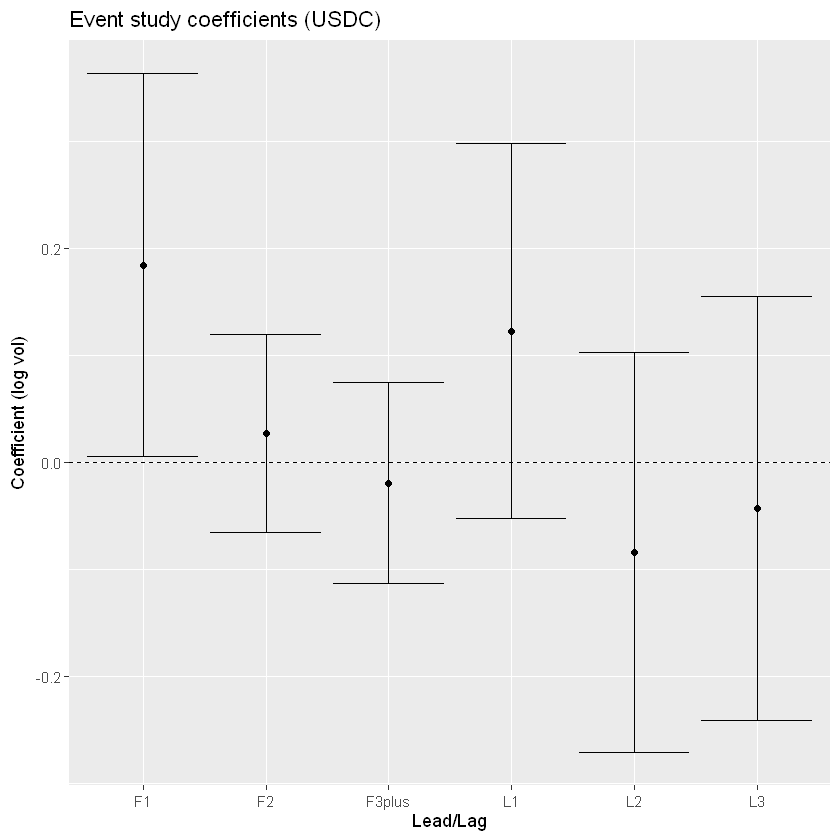

In [65]:
ann_windows2 <- ann_windows %>%
  mutate(Zcat = case_when(
     Z <= -3 ~ "-3_or_less",
     Z == -2 ~ "L2",
     Z == -1 ~ "L1",
     Z == 0  ~ "0",
     Z == 1  ~ "F1",
     Z == 2  ~ "F2",
     Z >= 3  ~ "3_or_more"
  ))


# easier: build dummies explicitly
ann_windows3 <- ann_windows2 %>%
  mutate(L3 = as.integer(Z == -3),
         L2 = as.integer(Z == -2),
         L1 = as.integer(Z == -1),
         F1 = as.integer(Z == 1),
         F2 = as.integer(Z == 2),
         F3plus = as.integer(Z >= 3))

evt_usdc <- feols(log_vol_usdc ~ L3 + L2 + L1 + F1 + F2 + F3plus | 0, cluster = ~ann_id, data = ann_windows3)
coefs <- broom::tidy(evt_usdc)
# plot with ggplot
coefs %>%
  filter(term %in% c("L3","L2","L1","F1","F2","F3plus")) %>%
  ggplot(aes(x = term, y = estimate)) +
   geom_point() + geom_errorbar(aes(ymin=estimate - 1.96*std.error, ymax=estimate + 1.96*std.error)) +
   geom_hline(yintercept = 0, linetype = "dashed") +
   labs(title="Event study coefficients (USDC)", y="Coefficient (log vol)", x="Lead/Lag")

coefs


- If a point is above 0, it indicates higher log-volume relative to the reference day (usually the day right before the event).

- If a point is below 0, it indicates lower log-volume.

- If the CI does not cross zero, the effect is statistically significant at ~5%.

- In your plot:

    Some leads (F1, F2) are near zero → stable volume before the announcement (no pre-trend)
    Lags (L1, L2, L3) show positive or negative jumps → the immediate effect of FOMC surprises on USDC trading volume.

    For example, if L1 CI is above zero → volume significantly increases one day after the event.

- ✅ Overall: The plot visually shows how stablecoin volume responds over time around the event. Pre-trends are small, which is good for causal interpretation.

In [70]:
library(stargazer)
stargazer(creg2, treg2, type = "text",
          title = "Regression Results for USDC and USDT",
          dep.var.labels = c("Log Volume USDC", "Log Volume USDT"),
          covariate.labels = c("D (Post FOMC)", "Z (Days from Event)", "D:Z"),
          digits = 3,
          star.char = c("*", "**", "***"),
          star.cutoffs = c(0.05, 0.01, 0.001))


% Error: Unrecognized object type.
% Error: Unrecognized object type.
